#### Importación de Librerías, definición del dataset y limpieza

Se resumen las tareas correspondientes para avanzar directamente a la resolución de la consigna del desafío.



In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format

#Cargo el Dataset
df = pd.read_csv("https://github.com/JuanPabloVeliz/Coder-DS/blob/main/Dataset/train.csv?raw=true")
print("Dataset cargado.")

#Elimino columnas innecesarias
df.drop(["ID", "Payment Plan", "Accounts Delinquent"], inplace=True, axis=1)
print("Se eliminaron las columnas ID, Payment Plan, y Accounts Delinquent")

#Renombro columnas equivocadas
df.rename(columns={"Home Ownership": "Unknown Value", "Employment Duration": "Home Ownership"}, inplace=True)

#Reduzco la cardinalidad de Loan Title
loan_titles = ["Consolidation", "Refinancing"]
df.loc[df["Loan Title"].str.contains(loan_titles[0], case=False), "Loan Title"] = loan_titles[0]
df.loc[df["Loan Title"].str.contains(loan_titles[1], case=False), "Loan Title"] = loan_titles[1]
df.loc[~df["Loan Title"].str.contains('|'.join(loan_titles), case=False), "Loan Title"] = "Other"


#Transformo las variables categóricas en numéricas
from sklearn.preprocessing import LabelEncoder

home_ownerships = LabelEncoder().fit(df["Home Ownership"])
initial_list_status = LabelEncoder().fit(df["Initial List Status"])
application_types = LabelEncoder().fit(df["Application Type"])
loan_titles =LabelEncoder().fit(df["Loan Title"])
batches_enrolled = LabelEncoder().fit(df["Batch Enrolled"].sort_values())
grades = LabelEncoder().fit(df["Grade"].sort_values())
sub_grades = LabelEncoder().fit(df["Sub Grade"].sort_values())

df["Home Ownership"] = home_ownerships.transform(df["Home Ownership"])
df["Initial List Status"] = initial_list_status.transform(df["Initial List Status"])
df["Application Type"] = application_types.transform(df["Application Type"])
df["Loan Title"] = loan_titles.transform(df["Loan Title"])
df["Batch Enrolled"] = batches_enrolled.transform(df["Batch Enrolled"])
df["Grade"] = grades.transform(df["Grade"])
df["Sub Grade"] = sub_grades.transform(df["Sub Grade"])

df["Verification Status"].replace({"Not Verified": 0, "Source Verified": 1, "Verified": 2}, inplace=True)


#Rebalanceo el dataset 
from sklearn.utils import resample

status_0 = df[df["Loan Status"]==0]
status_1 = df[df["Loan Status"]==1]

status_1_resampled = resample(status_1, n_samples=len(status_0), random_state=50)

resampled_df = pd.concat([status_1_resampled, status_0])

print("Cantidad de muestras luego del rebalanceo:")
print(resampled_df["Loan Status"].value_counts())


#Detecto y remuevo ouliers
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=0)
clf.fit(df)
isolated = clf.predict(resampled_df)
resampled_df["Outlier"] = isolated

clean_df = resampled_df[resampled_df["Outlier"] == 1]
clean_df.drop(columns="Outlier", inplace=True)

print("Resultado de la detección de outliers:")
print(resampled_df["Outlier"].value_counts())

Dataset cargado.
Se eliminaron las columnas ID, Payment Plan, y Accounts Delinquent
Cantidad de muestras luego del rebalanceo:
1    61222
0    61222
Name: Loan Status, dtype: int64
Resultado de la detección de outliers:
 1    110365
-1     12079
Name: Outlier, dtype: int64


### Evaluación del Modelo con las variables originales

In [106]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

#Preparo los datos

X = clean_df.drop(columns="Loan Status")
y = clean_df["Loan Status"]

#Separo train/test
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Preparo funciones para evaluación
def cf_matrix(pred, model):
    cf_matrix = confusion_matrix(df["Loan Status"], pred)
    ax = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
    ax.set_title('Matriz de confusion - '+ model)
    ax.set_xlabel('Valores predichos')
    ax.set_ylabel('Valores reales')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    return ax

def metrics(pred, model):
    print("Evaluación del modelo - ", model)
    print("Accuracy (tp + tn / Total): ","{:.2%}".format(accuracy_score(df["Loan Status"], pred)), " Etiquetados correctamente")
    print("Precision Score (tp / (tp + fp)): ","{:.2%}".format(precision_score(df["Loan Status"], pred, average="binary")), " Predicciones positivas acertadas")
    print("Recall Score (tp / (tp + fn)): ","{:.2%}".format(recall_score(df["Loan Status"], pred, average="binary")), " Casos positivos detectados")
    print("F1-Score (2 * (precision * recall ) / (precision + recall)): ","{:.2%}".format(f1_score(df["Loan Status"], pred, average="binary")), " Media armónica entre Precision y Recall")

Evaluación del modelo -  Decision Tree
Accuracy (tp + tn / Total):  95.87%  Etiquetados correctamente
Precision Score (tp / (tp + fp)):  74.45%  Predicciones positivas acertadas
Recall Score (tp / (tp + fn)):  84.28%  Casos positivos detectados
F1-Score (2 * (precision * recall ) / (precision + recall)):  79.06%  Media armónica entre Precision y Recall


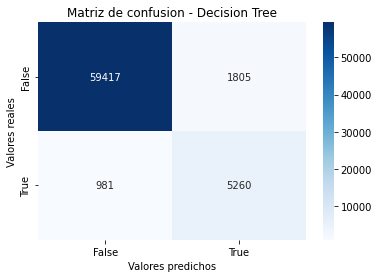

In [107]:
# Decision Tree
#Paso 1 :Instanciar
model = DecisionTreeClassifier(random_state=0)
#Paso 2 : Fit con la información
model.fit(X_train, y_train)
#Paso 3 : Predicción
pred = model.predict(df.drop(columns="Loan Status"))

cf_matrix(pred, "Decision Tree")
metrics(pred, "Decision Tree")

La conclusión hasta el momento es que el modelo está respondiendo positivamente. Las métricas están arrojando valores muy razonables. Es importante destacar la performance medida con el Recall Score, que indica que el modelo puede predecir aproximadamente el 84% de los casos positivos de default.

### Feature Selection y reevaluación del modelo

A continuación realizo un proceso de creación de nuevas variables sintéticas a partir de las variable originales y luego un proceso de eliminación de variables con el objetivo de ayudar a mejorar la performance del modelo.

Las dos variables sintéticas, se crean tanto en el Dataset original como en el procesado. El dataset procesado se utiliza para el entrenamiento y el dataset original se utiliza para hacer las predicciones.  

In [108]:
#Delinquency indica con True si existió algún evento, False si no se registra ninguno.
clean_df["Delinquency"] = clean_df["Delinquency - two years"] != 0
df["Delinquency"] = df["Delinquency - two years"] != 0

#Fundad / Loan indica el coeficiente de fondeo sobre el valor del préstamo solicitado.
clean_df["Funded / Loan"] = clean_df["Funded Amount"] + clean_df["Funded Amount Investor"] / clean_df["Loan Amount"]
df["Funded / Loan"] = df["Funded Amount"] + df["Funded Amount Investor"] / df["Loan Amount"]

Habiendo incorporado estas nuevas variables utilizo PCA para identificar las más importantes y así poder de descartar las que no estén aportando valor al modelo.

Como se ve a continuación, reduciendo el modelo a sus 2 componentes principales, vemos que el PCA1 es capaz de explicar aproximadamente el 90% de las variaciones.

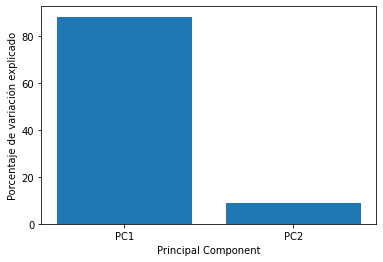

In [109]:
from sklearn.decomposition import PCA

x = clean_df.drop(columns="Loan Status")
y = clean_df["Loan Status"]

#Intancio el objeto pca
pca = PCA(n_components=2)

#Entreno usando el dataset escalado
pca.fit(X)

#Genero los datos para el modelo
pca_data = pca.transform(X)

#% de variación que explica cada componente
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)

#Genero los nombre de los componentes, 1 por cada uno incluído en "per_var"
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Porcentaje de variación explicado')
plt.xlabel('Principal Component')
plt.show()


El paso siguiente es entonces analizar cuáles son las variables más influyentes en cada componente.

Sorprendentemente, se ve que cada componente está vinculado a 1 sola variable. Esto indicaría que podríamos mantener la eficacia del modelo utilizando sólo las variables comprometidas.

In [110]:
## Obtengo los pesos de las variables en el primer componente
pesos_PCA1 = pd.Series(pca.components_[0], index=X.columns)
pesos_PCA2 = pd.Series(pca.components_[1], index=X.columns)

# Muestro los primeros 5 elementos de cada componente 
print("Pesos PCA1")
print(pesos_PCA1.abs().sort_values(ascending=False)[0:5])

print("Pesos PCA2")
print(pesos_PCA2.abs().sort_values(ascending=False)[0:5])

Pesos PCA1
Total Current Balance          1.00
Unknown Value                  0.00
Total Revolving Credit Limit   0.00
Revolving Balance              0.00
Loan Amount                    0.00
dtype: float64
Pesos PCA2
Unknown Value                  1.00
Total Revolving Credit Limit   0.00
Loan Amount                    0.00
Funded Amount                  0.00
Revolving Balance              0.00
dtype: float64


A continuación, defino un nuevo dataset incluyendo sólo las columnas relacionadas con los componentes principales.
Luego, utilizo este dataset resumido para entrenar un nuevo Decision Tree y realizo su evaluación.

Evaluación del modelo -  Decision Tree
Accuracy (tp + tn / Total):  96.13%  Etiquetados correctamente
Precision Score (tp / (tp + fp)):  76.23%  Predicciones positivas acertadas
Recall Score (tp / (tp + fn)):  84.52%  Casos positivos detectados
F1-Score (2 * (precision * recall ) / (precision + recall)):  80.16%  Media armónica entre Precision y Recall


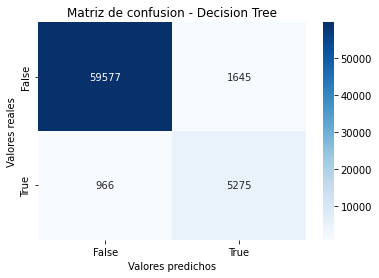

In [111]:
pca_df = clean_df[["Total Current Balance", "Unknown Value", "Loan Status"]]

#Preparo los datos

X = pca_df.drop(columns="Loan Status")
y = pca_df["Loan Status"]

#Separo train/test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Decision Tree
#Paso 1 :Instanciar
model = DecisionTreeClassifier(random_state=0)
#Paso 2 : Fit con la información
model.fit(X_train, y_train)
#Paso 3 : Predicción
pred = model.predict(df[["Total Current Balance", "Unknown Value"]])

cf_matrix(pred, "Decision Tree")
metrics(pred, "Decision Tree")

## Conclusiones

Tal como inferimos a partir del resultado de la aplicación del PCA, utilizando sólo las 2 variables destacadas es suficiente para que el modelo mantenga una performance aceptable.

Respecto a las las variables utilizadas, una de ellas corresponde a una serie de datos que no estaba correctamente identificada en el dataset original. Si se tratara de datos de un negocio real, resultaría muy importante solicitar al proveedor de los datos una aclaración sobre a qué se refiere la variable en cuestión.

Respecto al modelo, el haber reducido la cantidad de variables de las 32 iniciales a sólo 2 es una ganancia muy relevante ya que resultará ser un modelo de aplicación más simple a la hora de hacer el despliegue.